# Normalization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings; warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv('../data/E_B02_Sequenz_1.csv', delimiter=';')
df2 = pd.read_csv('../data/E_B02_Sequenz_2.csv', delimiter=';')
df3 = pd.read_csv('../data/E_B02_Sequenz_3.csv', delimiter=';')

df = df1.append(df2).append(df3)
print(len(df), len(df1), len(df2), len(df3))


df.head()

255 87 84 84


,geschwindigkeit,tonlage,schallstaerke
0,87,257,33
1,84,227,33
2,82,231,34
3,79,240,37
4,76,232,41


In [3]:
from sklearn.preprocessing import MinMaxScaler

speed_scaler = MinMaxScaler().fit(df['geschwindigkeit'].to_numpy().reshape(-1, 1))

In [4]:
mean_speed_last_ten = df1.rolling(window=10)['geschwindigkeit'].mean().to_numpy()[-1].reshape(-1, 1)
mean_speed_last_ten, df['geschwindigkeit'].mean(), speed_scaler.transform(mean_speed_last_ten)

(array([[112.6]]), 96.55686274509804, array([[0.59381443]]))

We are 59% confident that the speed is "high". Which gives us two basic measures:

    m1(A, Ü, W, F) = 0.8538, m1(Omega) = 0.146
    m2(F, E) = 0.146 = 0.8538

# Portions in Low, Normal, High 

Portion of values above upper quartile in last ten seconds.

In [9]:
schema = set(df.columns)

last_window = df1[-10:]
last_window

,geschwindigkeit,tonlage,schallstaerke
77,115,449,49
78,118,527,48
79,119,521,48
80,116,516,45
81,113,466,46
82,109,439,46
83,109,452,47
84,111,436,49
85,111,432,44
86,105,411,38


In [126]:
rolling = df1.rolling(window=10)

windows = pd.DataFrame(columns=['low', 'normal', 'high', 'col'])

for col in df:
    def portion_in_lower_quartile(w):
        return np.sum(
                1 for x in w 
                if x <= df[col].quantile(0.25)
        ) / len(w)
    
    def portion_in_upper_quartile(w):
        return np.sum(
                1 for x in w 
                if x >= df[col].quantile(0.75)
        ) / len(w)
    
    def portion_in_between_quartiles(w):
        return np.sum(
                1 for x in w 
                if (x > df[col].quantile(0.25)
                    and x < df[col].quantile(0.75))
        ) / len(w)
    
    
    col_windows = pd.DataFrame()
    col_windows['low'] = rolling[col].agg(portion_in_lower_quartile)
    col_windows['normal'] = rolling[col].agg(portion_in_between_quartiles)
    col_windows['high'] = rolling[col].agg(portion_in_upper_quartile)
    col_windows['col'] = [col] * len(col_windows)
    windows = windows.append(col_windows)

windows = windows.sort_index()
index = pd.MultiIndex.from_arrays([windows.index, windows.col], 
                                  names=('window', 'col'))
windows = windows.drop('col', axis=1).set_index(index)
windows

low  normal  high
window col                               
0      geschwindigkeit  NaN     NaN   NaN
       schallstaerke    NaN     NaN   NaN
       tonlage          NaN     NaN   NaN
1      geschwindigkeit  NaN     NaN   NaN
       schallstaerke    NaN     NaN   NaN
...                     ...     ...   ...
85     geschwindigkeit  0.0     0.3   0.7
       tonlage          0.0     0.0   1.0
86     geschwindigkeit  0.0     0.3   0.7
       tonlage          0.0     0.0   1.0
       schallstaerke    0.0     0.8   0.2

[261 rows x 3 columns]

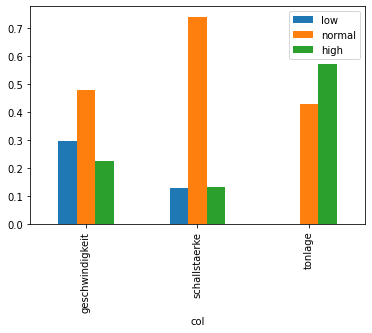

In [137]:
windows.groupby('col').mean().plot(kind='bar')

Problem! Tonlage never low??

Example Window:

In [128]:
windows.loc[85]

,low,normal,high
col,,,
schallstaerke,0.0,0.8,0.2
geschwindigkeit,0.0,0.3,0.7
tonlage,0.0,0.0,1.0


This gives us three basic measures:

    # high , low, normal
    mSpeed(A, Ü, W, F) = 0.7, mSpeed(F, E) = 0, mSpeed(Omega) = 0.3
    mPitch(A, Ü, W, F) = 1.0, mPitch(E, T) = 0, mPitch(Omega) = 0
    mIntensity(Ü, W, F) = 0.2, mIntensity(T) = 0, mIntensity(Omega) = 0.8

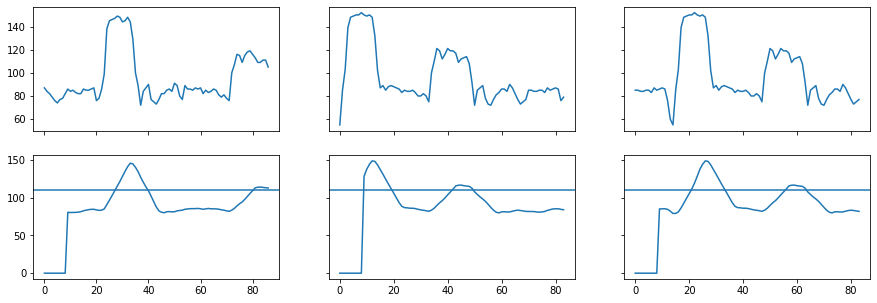

In [123]:
dfs = (df1, df2, df3)
vals = tuple(map(lambda df: df['geschwindigkeit'], dfs))
windows = tuple(map(lambda df: df.rolling(window=10)['geschwindigkeit'],
                   dfs))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5),
                         sharey='row', sharex='col')
val_axes, window_axes = axes
                         
for val, ax in zip(vals, val_axes):
    val.plot(ax=ax)

for window, ax in zip(windows, window_axes):
    window.mean().fillna(0).plot(ax=ax)
    ax.axhline(df['geschwindigkeit'].quantile(0.75))